# Initialization for Notebook

In [3]:
import os
import sys
import torch
import scipy
import scipy.io
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import medfilt, savgol_filter, wiener
from scipy.linalg import pinv
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
os.chdir('../../SpectraFit/')
import data_processing.preprocessing as preprocessing
from config import dataset_path
from utils import beerlamb_multi

sns.set()

#### Load piglet data

Text(0.5, 1.0, 'Reference spectrum')

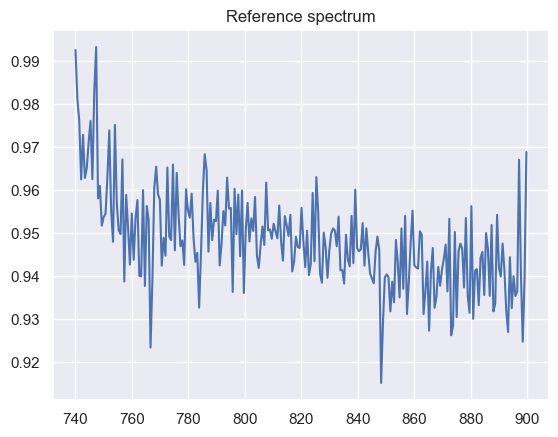

In [4]:
left_cut = 740
right_cut = 900
reference_index = 100 # starting spectrum for inference
time_cut = 500 # at what timepoint to stop inference

# load data
img_mat = scipy.io.loadmat(dataset_path + 'LWP498/LWP498_Ws_24Apr2017_15.mat')
dark_ref = scipy.io.loadmat(dataset_path + 'LWP498/LWP498 _DarkCount_24Apr2017.mat')['DarkCount'].astype(float) # shape (k,n)
white_ref = img_mat['refIntensity'].astype(float) # shape (k,m)
spectr = img_mat['spectralDataAll'].astype(float)[:,:time_cut].T # shape (time_cut, k)
band_centers = img_mat['wavelengths'].astype(float).squeeze() # shape (k,)
concentrations_paper = img_mat['AllConcentration']

#To find HI_start and HI_stop:
#we take the row in the Excel where FiO2 drops, but need to add offset as Excel file starts at different timepoint
HI_start = 143
HI_stop = 274
outcome = 0

# average dark and white reference and add dimension for shape (1,k)
white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]

# extract wavelengths between 760 and 900
band_limits = [left_cut, right_cut]
spectr, _ = band_removal(spectr, band_limits, band_centers)
white_ref, _ = band_removal(white_ref, band_limits, band_centers)
dark_ref, band_centers_new = band_removal(dark_ref, band_limits, band_centers)


# calibrate spectra
spectr_calib = calibrate_img(spectr, white_ref, dark_ref)
ref_spectr_calib = spectr_calib[reference_index, :]

# plot reference spectrum
plt.figure()
plt.plot(band_centers_new, ref_spectr_calib)
plt.title("Reference spectrum")

#### Load cytochrome spectra

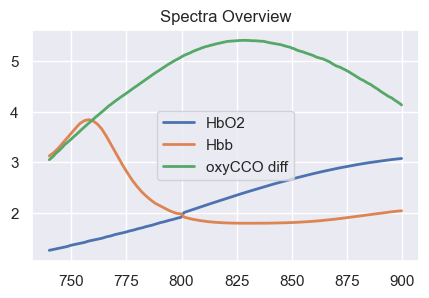

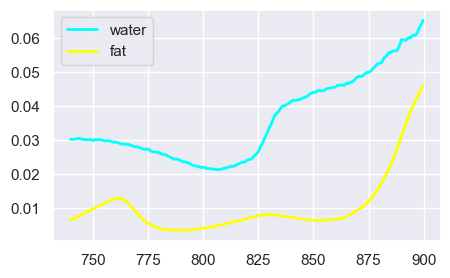

In [5]:
# load cytochrome spectra
molecules, x = preprocessing.read_molecules(left_cut, right_cut, band_centers_new)
y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat = molecules

M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa - y_creda))))
M_pinv = pinv(M)
m = M.shape[1] # number of cytochromes to fit

# plot cytochrome spectra
plt.figure(figsize=(5,3))
coef = ["HbO2", "Hbb", "oxyCCO diff"]
coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda]
for i in range(len(coef)):
    plt.plot(band_centers_new, M[:,i], label=coef[i], linewidth=2)
plt.title("Spectra Overview")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(band_centers_new, y_water, color="cyan", label="water", linewidth=2)
plt.plot(band_centers_new, y_fat, color="yellow", label="fat", linewidth=2)
plt.legend()

In [109]:
def project_img(img, white_ref, dark_ref):
    '''
    Project the image onto the subspace orthogonal to the illumination spectrum.
    input:
        img: image to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        white_ref: white reference, shape (...,k) where m is the number of white reference pixels
        dark_ref: white reference, shape (...,k) where n is the number of dark reference pixels
    output:
        projected image as np.array
    '''
    img, white_ref, dark_ref = get_array(img), get_array(white_ref), get_array(dark_ref)
    # calculate reflectance
    R = np.subtract(img, dark_ref, dtype=np.float32)
    # calculate illumination spectrum E
    E = np.mean(np.subtract(white_ref, dark_ref, dtype=np.float32), axis=-2).squeeze()
    E = smooth_spectral(E, 5)
    # get mapping to subspace orthogonal to E
    P_E = np.eye(E.shape[0]) - np.outer(E, E)/np.dot(E, E)
    # apply mapping to data
    # R_E = np.einsum('ij,klj->kli', P_E, R) 
    R_E = np.einsum('ij,...j->...i', P_E, R) 
    return R_E, P_E

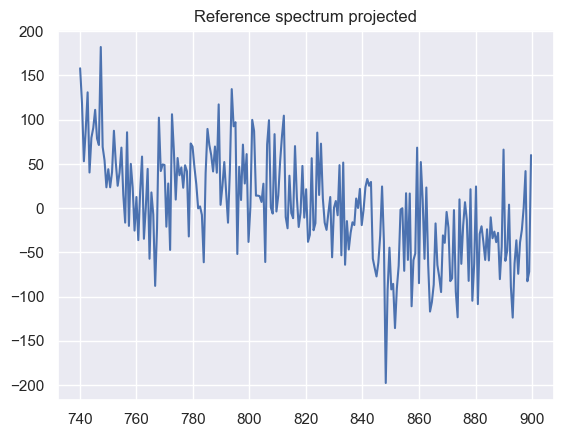

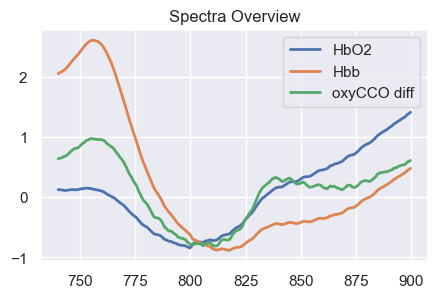

In [132]:
spectr_proj, P_E = project_img(spectr, white_ref, dark_ref)
ref_spectr_proj = spectr_proj[reference_index, :]

# plot projected spectrum
plt.figure()
plt.plot(band_centers_new, ref_spectr_proj)
plt.title("Reference spectrum projected")

M_proj = np.einsum('ij,i...->j...', P_E, M)

# plot cytochrome spectra
plt.figure(figsize=(5,3))
coef = ["HbO2", "Hbb", "oxyCCO diff"]
for i in range(len(coef)):
    plt.plot(band_centers_new, M_proj[:,i], label=coef[i], linewidth=2)
plt.title("Spectra Overview")
plt.legend()

# Scattering Notebook

We want to learn whether and how we can include scattering into the
Beer-Lambert Law. We remember that we can describe the modified Beer
Lambert law as
$$
A(t,\lambda)=\sum_{i}\mu_{i}(\lambda)\cdot c_{i}\cdot\text{PL}(\lambda)
$$
When we assume that scattering does not change in time, it is possible
to use the differential modified Beer Lambert law (dMBLL) to infer
the concentrations as
$$
\Delta A\left(\Delta t,\lambda\right)=A(t_{1},\lambda)-A(t_{0},\lambda)=\text{PL}(\lambda)\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}
$$
cancelling time-independent scattering effects. To improve upon this
model, we now assume that there are time-dependent scattering effects
such that 
$$
A(t,\lambda)=\text{PL}(\lambda)\left(\mu_{a}(t,\lambda)+\mu_{s}(t,\lambda)\right)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot c_{i}(t)+\mu_{s}(t,\lambda)\right)
$$
of the form
$$
\mu_{s}(t,\lambda)=\sum_{k}a_{k}(t)\cdot\left(\frac{\lambda}{500nm}\right)^{-b_{k}(t)}
$$
based on \cite{Oshina2021,Jacques2013}. This yields a new version
of the dMBLL as
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+\mu_{s}(t_{2},\lambda)-\mu_{s}(t_{1},\lambda)\right)
$$
If we assume that the majority of the scattering originates from time-independent
factors, we might assume
$$
\mu_{s}(t,\lambda)=a_{1}(t)\cdot\left(\frac{\lambda}{500nm}\right)^{-b_{1}(t)}
$$
such that
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-a(t_{1})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right)
$$
We want to test the following scenarios:
1. The most general case where both $a(t)$ and $b(t)$ vary in time, such that for each measured timepoint $t_i$ the parameters $a(t_i), b(t_i)$ need to be inferred, including a scattering estimate for the reference time $a(t_1),b(t_1)$. This is a challenging scenario as it presents high parameter ambiguity.

2. Let $a(t_{i})=a(t_{1})=a$. Time-dependent
scattering might change the scattering behavior, i.e. the wavelength
dependency $b(t)$, rather than changing the scattering probability
$a(t)$. The scattering probability is increased when tissue becomes
homogeneously denser {[}TODO: citation{]}, however during and after
HI we expect tissue changes that alter scattering behavior. With this
assumption, the problem in each timestep remains non-linear. The simplified
problem can be formulated as
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a\left[\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right]\right)
$$
For each timepoint we estimate $b(t_i)$. We empirically observed that different values of $a$ essentially scale $b(t_2)$, therefore we choose $a=1$ for simplicity.

3. Let $b(t_{i})=b(t_{1})=b$. Even though this might
not be a physically relevant case, it greatly simplifies problem complexity
as the problem then becomes linear after optimization of $b$, since
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+\Delta a\left(\frac{\lambda}{500nm}\right)^{-b}\right)
$$

4. Let $a(t_1)=0$ such that we assume the absence of scattering at the beginning of measurement. This yields
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}\right)
$$

As wavelength range we use $[740nm,900nm]$ as it shows significantly better fits below $760nm$ as we will observe below. For simplicity we assume $\text{PL}(\lambda)=1$.

We first go through the four scenarios for the piglet chosen above and then compute the error for a subset of the piglets to quantitatively compare the four cases.

In [7]:
def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(8,4))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(np.arange(reference_index, time_cut),coef_list[reference_index:time_cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()

def plot_concentrations(c_i_list, title):
        plt.figure(figsize=(8,4))
        c_i_list = np.vstack(c_i_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(np.arange(reference_index, time_cut), c_i_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(np.arange(reference_index, time_cut), c_i_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(np.arange(reference_index, time_cut), c_i_list[:, 0] + c_i_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()            
    
def plot_a_b(a_s, b_s):
    fig, axs = plt.subplots(2, 1, figsize=(16,9))
    b_s = np.vstack(b_s)
    a_s = np.vstack(a_s)
    axs[0].plot(b_s[:, 0], label="b", linewidth=2)
    axs[1].plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
    plt.legend()



# Scenario 0

$$
\Delta A(t,\lambda)=\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)

In [10]:
# determines concentrations without scattering using least squares
def optimisation_pinv(spectr_t1, spectr_t2, M):
    delta_A = np.log(np.divide(spectr_t1, spectr_t2))
    M_pinv = pinv(M)
    X = M_pinv @ delta_A
    found_spectrum = np.exp(-(M @ X)) * spectr_t1
    
    residual = M @ X - delta_A
    
    return X, found_spectrum, residual

def scenario_0_given_t1(spectr, M, need_plot=True):
    
    delta_c_i_list = []
    error_list = []
    
    ref_spectr = spectr[reference_index, :]
    for i in range(reference_index, time_cut):
        spectr_t2 = spectr[i, :]
        spectr_t2[spectr_t2 <= 0] = 0.0001    
        delta_c_i, found_spectrum, residual = optimisation_pinv(ref_spectr, spectr_t2, M)

        delta_c_i_list.append(delta_c_i)
        error_list.append(np.linalg.norm(residual, ord=2))
            
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(band_centers_new, -np.log(spectr_t2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(band_centers_new, -np.log(found_spectrum / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        # plot_concentrations_paper(concentrations_paper)
        plot_concentrations(delta_c_i_list, "Scenario 0 - Computed Without Scattering")

    return np.array(error_list), np.array(delta_c_i_list)

Mean error: 0.16156403232085698
Mean error: 0.1318592241711649


IndexError: index 4 is out of bounds for axis 1 with size 4

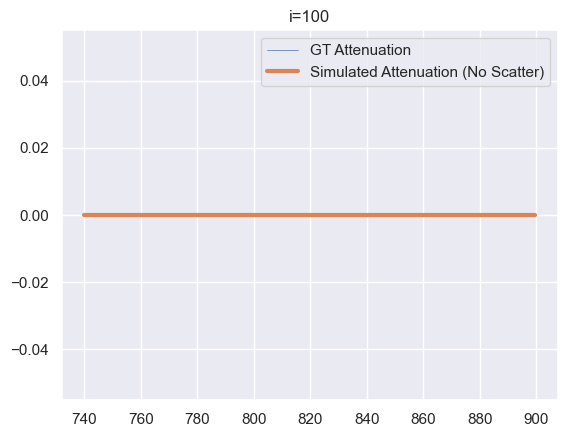

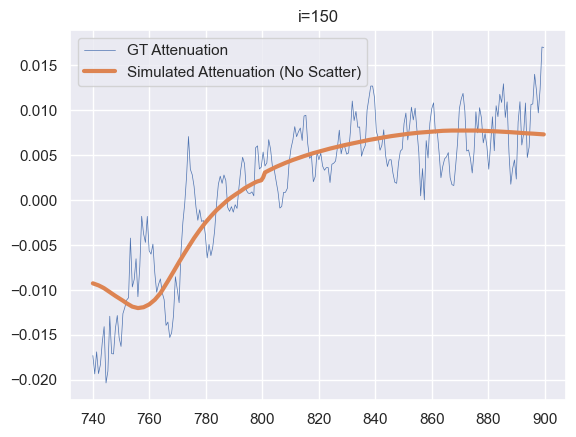

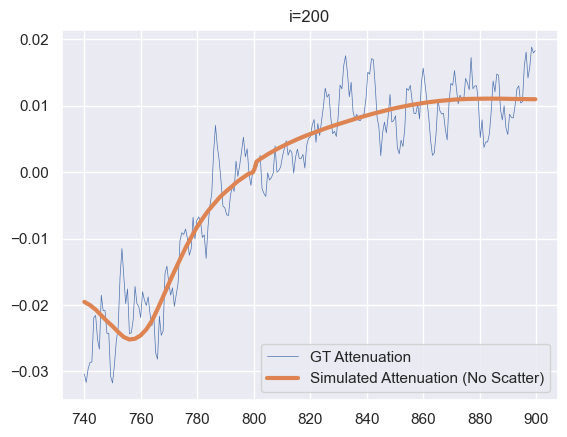

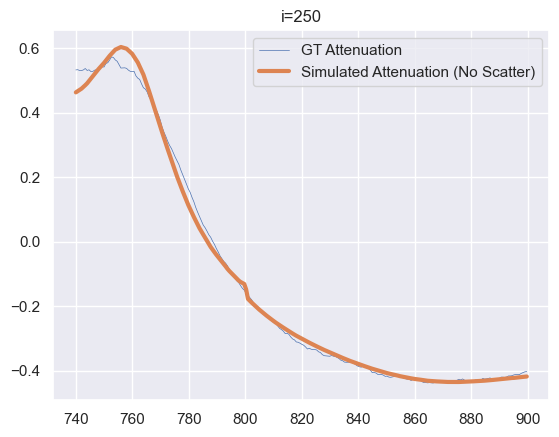

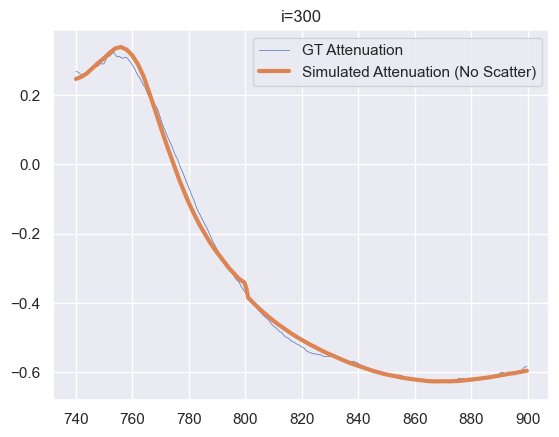

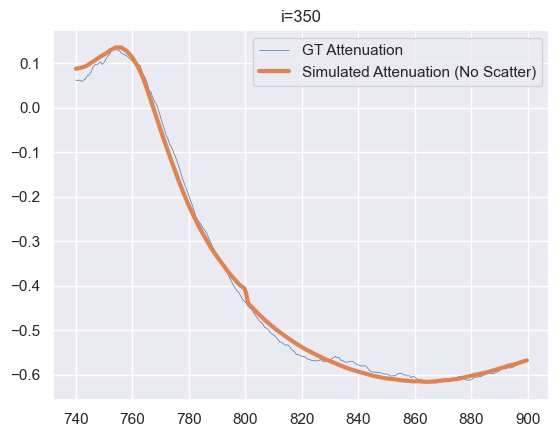

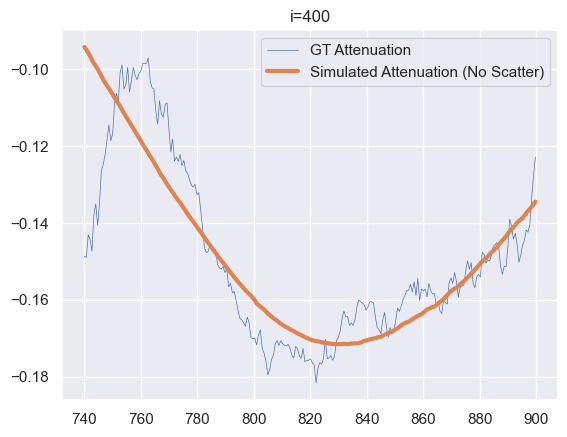

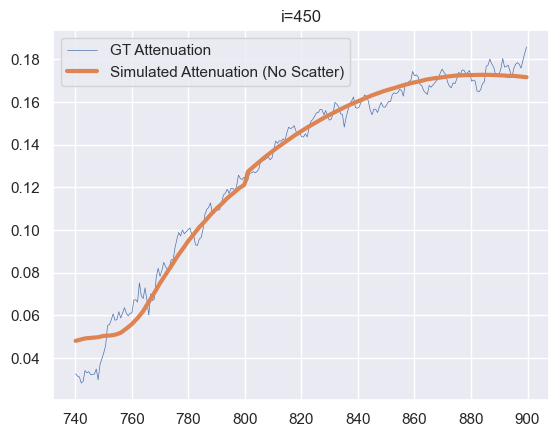

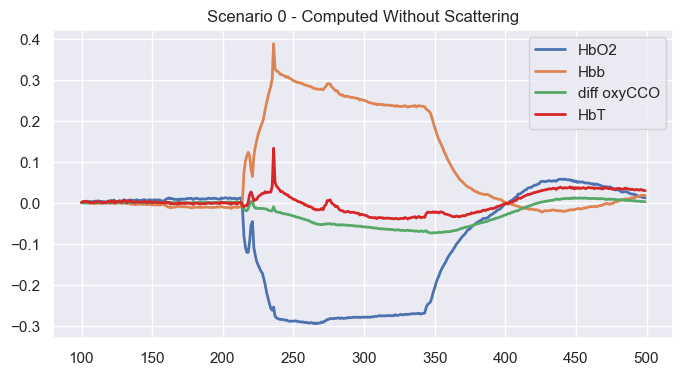

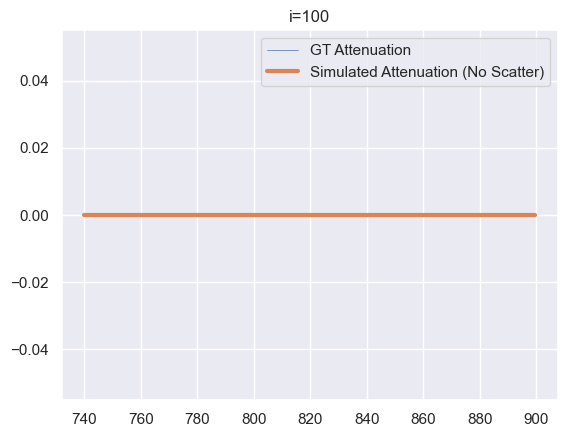

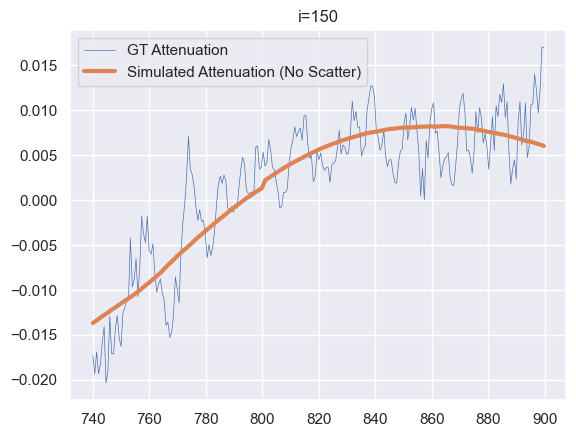

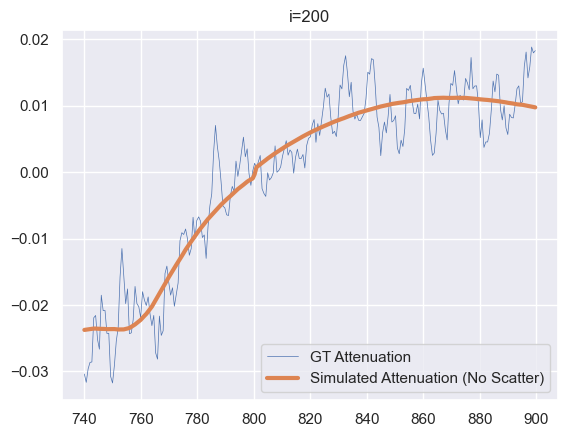

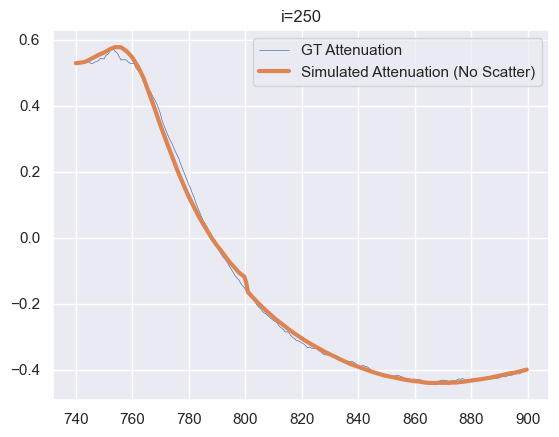

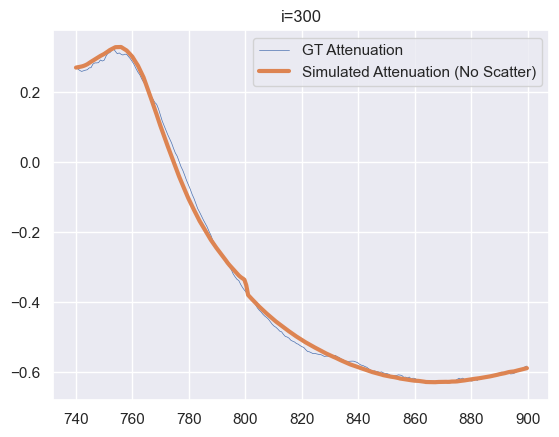

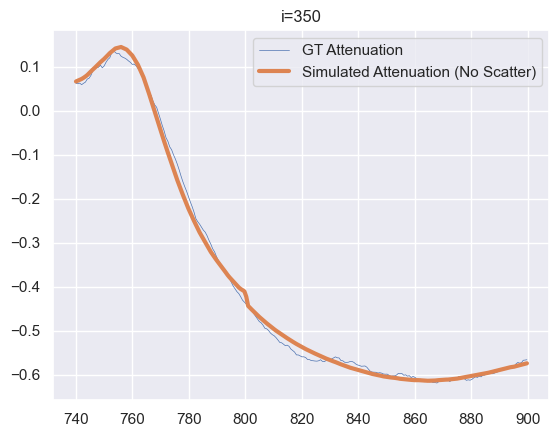

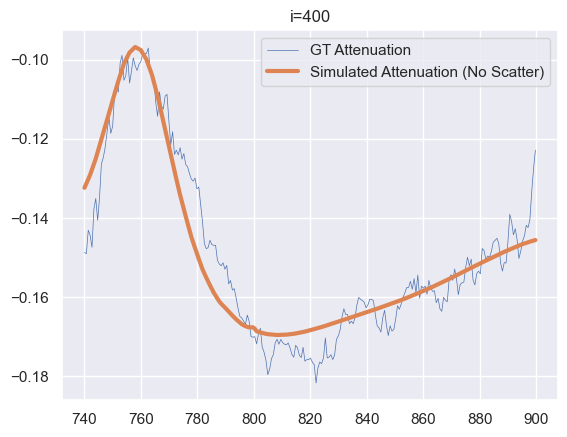

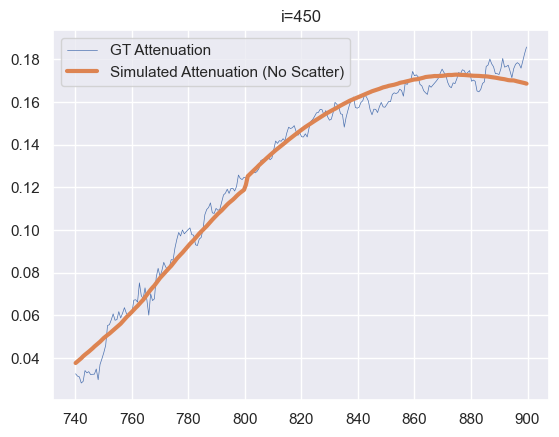

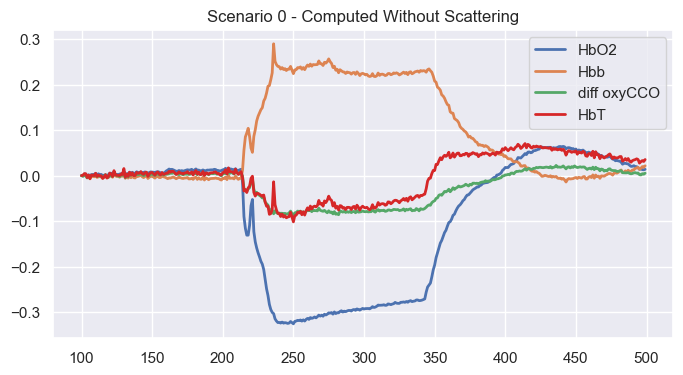

<Figure size 640x480 with 0 Axes>

In [11]:
spectr_calib_smooth = smooth_spectral(spectr_calib, 5)


error, delta_c_i_list = scenario_0_given_t1(spectr_calib_smooth, M, need_plot=True)
print("Mean error:", np.mean(error))
# fig, ax = plt.subplots(figsize=(5,4))
# ax.plot(np.mean(np.abs(error), axis=0), label="standard")

# # add water
# M_water = np.hstack((M, y_water[:, np.newaxis]))
# error, delta_c_i_list = scenario_0_given_t1(spectr_calib_smooth, M_water, need_plot=True)
# print("Mean error:", np.mean(error))

# expand M by a column of ones
M_ones = np.hstack((M, np.ones((M.shape[0], 1))))
error, delta_c_i_list = scenario_0_given_t1(spectr_calib_smooth, M_ones, need_plot=True)
print("Mean error:", np.mean(error))
# ax.plot(np.mean(np.abs(error), axis=0), label="with ones")
# fig2, ax2 = plt.subplots(figsize=(8,4))
# ax2.plot(delta_c_i_list[:, 3], label="brightness change")

# # add water
# M_water = np.hstack((M_ones, y_water[:, np.newaxis]))
# error, delta_c_i_list = scenario_0_given_t1(spectr_calib_smooth, M_water, need_plot=True)
# print("Mean error:", np.mean(error))


plt.figure()
plt.plot(delta_c_i_list[:, 4], label="water change")
plt.plot(delta_c_i_list[:, 3], label="brightness change")

# perform pca on error
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(error)
# plot pca weights
# plt.figure()
# plt.plot(pca.components_[0, :])

# M_ones_pca = np.hstack((M_water, pca.components_[0, :][:, np.newaxis]))
# error, delta_c_i_list = scenario_0_given_t1(spectr_calib_smooth, M_ones_pca, need_plot=True)
# print("Mean error:", np.mean(np.abs(error)))
# # ax.plot(np.mean(np.abs(error), axis=0), label="with pca")

# Scenario 0.5
Assume only Rayleigh scattering
$$
\Delta A(t,\lambda)=\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t) + \Delta a\cdot\left(\frac{\lambda}{500nm}\right)^{-4}

In [14]:
# determines a_i given b using least squares
def optimisation_scattering_pinv(spectr_t1, spectr_t2, b, M):
    S = (band_centers_new[...,None]/500)**(-b)
    M_S = np.hstack((M,S))
    M_S_pinv = pinv(M_S)
    delta_A = np.log(np.divide(spectr_t1, spectr_t2))
    X = M_S_pinv @ delta_A
    m = M.shape[1]
    delta_c_i = X[0:m]
    delta_a = X[m:]
    found_spectrum = np.exp(-(M @ delta_c_i + S @ delta_a)) * spectr_t1

    residual = (M @ delta_c_i + S @ delta_a) - delta_A

    return X, found_spectrum, residual

def scenario_05_given_t1(spectr, M, need_plot=True):
    
    delta_c_i_list = []
    error_list = []
    delta_a_list = []
    
    ref_spectr = spectr[reference_index, :]
    for i in range(reference_index, time_cut):
        spectr_t2 = spectr[i, :]
        spectr_t2[spectr_t2 <= 0] = 0.0001    
        X, found_spectrum, residual = optimisation_scattering_pinv(ref_spectr, spectr_t2, 1.6, M)

        m = M.shape[1]
        delta_c_i_list.append(X[0:m])
        delta_a_list.append(X[m:])
        error_list.append(np.linalg.norm(residual, ord=2))
            
        # if need_plot and i % 50 == 0:
        #     plt.figure()
        #     plt.plot(band_centers_new, -np.log(spectr_t2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
        #     plt.plot(band_centers_new, -np.log(found_spectrum / ref_spectr), label='Simulated Attenuation (Rayleigh Scatter)', linewidth=3)
        #     plt.title("i=" + str(i))
        #     plt.legend()

    
    if need_plot:
        # plot_concentrations_paper(concentrations_paper)
        plot_concentrations(delta_c_i_list, "Scenario 0 - Computed With Rayleigh Scattering")
        plt.figure()
        plt.plot(delta_a_list)

    return np.array(error_list), np.array(delta_c_i_list)

Mean error: 0.13003427352124977
Mean error: 0.11213825915760701
Mean error: 0.12139030764384864
Mean error: 0.1008895067059185


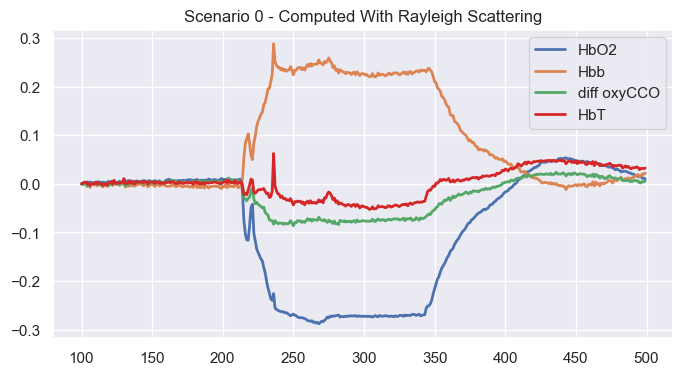

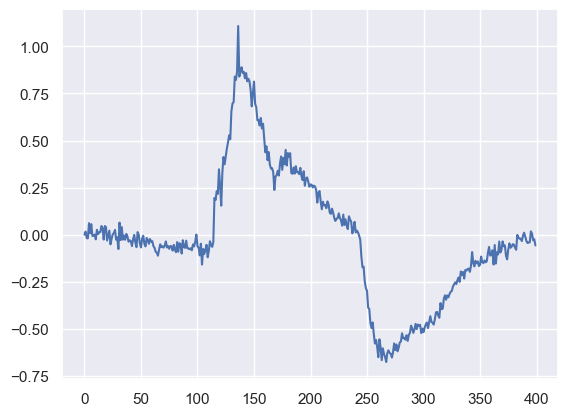

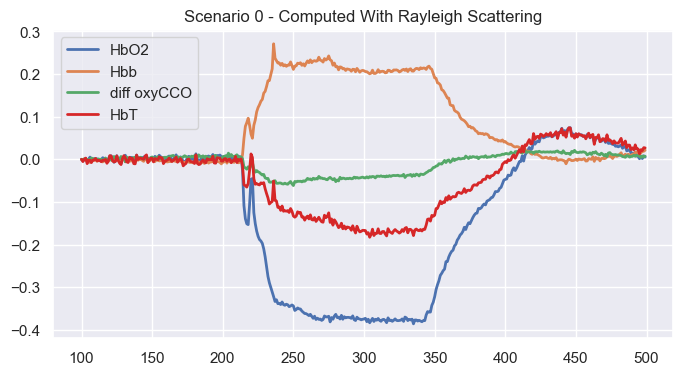

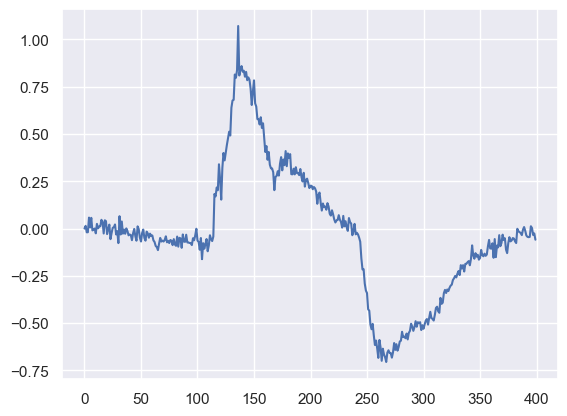

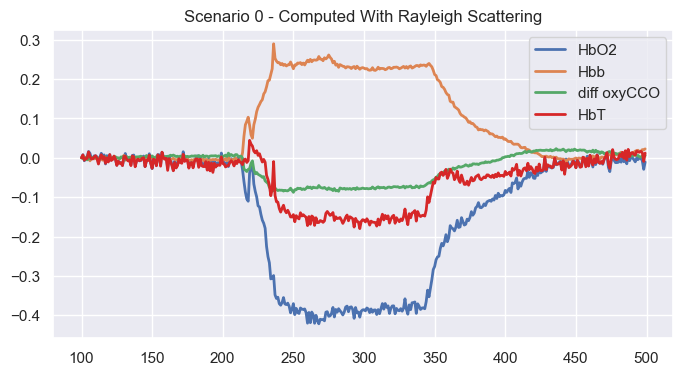

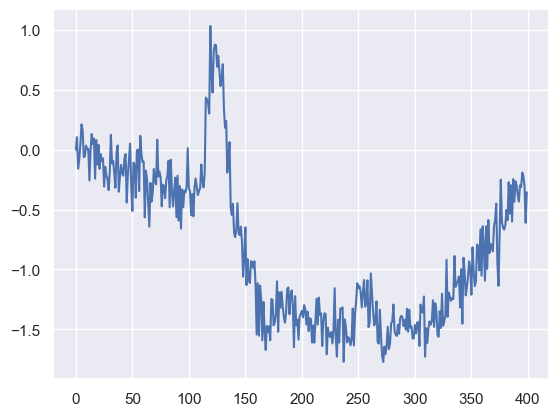

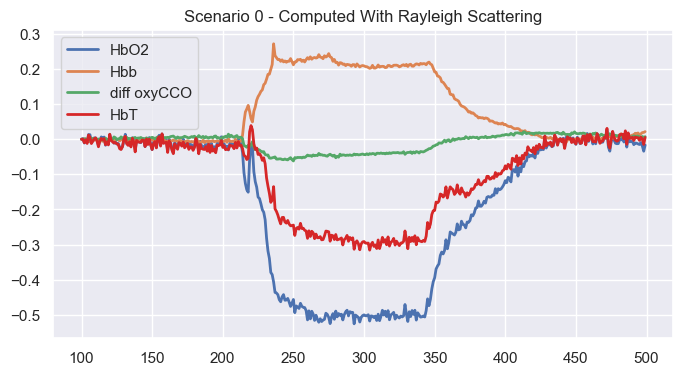

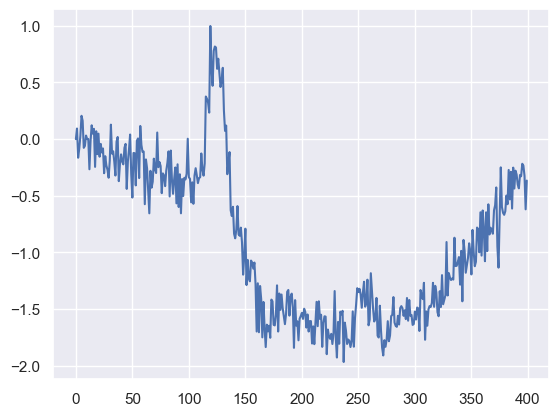

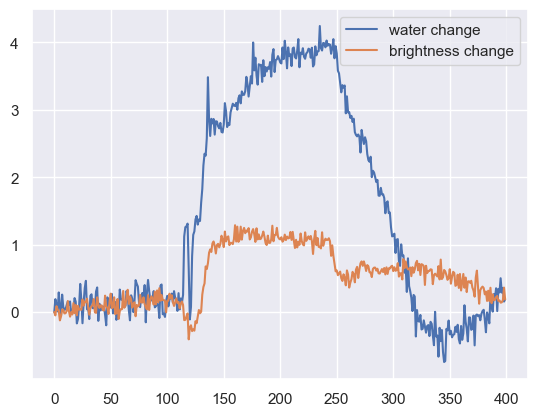

In [15]:
error, delta_c_i_list = scenario_05_given_t1(spectr_calib_smooth, M, need_plot=True)
print("Mean error:", np.mean(error))
# fig, ax = plt.subplots(figsize=(5,4))
# ax.plot(np.mean(np.abs(error), axis=0), label="standard")

# add water
M_water = np.hstack((M, y_water[:, np.newaxis]))
error, delta_c_i_list = scenario_05_given_t1(spectr_calib_smooth, M_water, need_plot=True)
print("Mean error:", np.mean(error))

# expand M by a column of ones
M_ones = np.hstack((M, np.ones((M.shape[0], 1))))
error, delta_c_i_list = scenario_05_given_t1(spectr_calib_smooth, M_ones, need_plot=True)
print("Mean error:", np.mean(error))
# ax.plot(np.mean(np.abs(error), axis=0), label="with ones")
# fig2, ax2 = plt.subplots(figsize=(8,4))
# ax2.plot(delta_c_i_list[:, 3], label="brightness change")

# add water
M_water = np.hstack((M_ones, y_water[:, np.newaxis]))
error, delta_c_i_list = scenario_05_given_t1(spectr_calib_smooth, M_water, need_plot=True)
print("Mean error:", np.mean(error))


plt.figure()
plt.plot(delta_c_i_list[:, 4], label="water change")
plt.plot(delta_c_i_list[:, 3], label="brightness change")
plt.legend()

# Scenario 1

We find parameters $a(t_i), b(t_i)$ for
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-a(t_{1})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right)
$$

We examine scenario 1 by optimizing for different values of $a(t_1), b(t_1)$ and then pick the minimal $a(t_1), b(t_1)$ that was found to show the inference results, including the found fit for the observed absorption and the inferred concentrations.

In [16]:
# error function for optimisation of model with scattering
def f(X,*arg):
    delta_A = arg[0]
    a_t1, b_t1 = arg[1], arg[2]
    S = arg[3] # scattering model
    M = arg[4] # cytochrome spectra
    m = M.shape[1]
    delta_c_i = X[:m]
    a_t2 = X[m:(m+1)]
    b_t2 = X[(m+1):(m+2)]
    residual = (M @ delta_c_i) + S(a_t1, b_t1, a_t2, b_t2) - delta_A
    # print(np.linalg.norm(residual, ord=2))
    return residual

def scenario_1_given_t1(spectr, a_t1, b_t1, M, need_plot=True):

    # scattering component
    def S(a_t1, b_t1, a_t2, b_t2):
        mu_s = ((band_centers_new/500)**(-b_t2)) * a_t2 - ((band_centers_new/500)**(-b_t1)) * a_t1
        return mu_s
    
    delta_c_i_list = []
    a_list = []
    b_list = []
    error_list = []
    
    #initial_estimation = [0,0,0,0,1] (for delta_c_1, ..., delta_c_m, a_t2, b_t2)
    m = M.shape[1]
    current_x = np.zeros(m+2)
    current_x[-1] = b_t1
    current_x[-2] = a_t1
    left_bound = np.append(np.ones(m)*(-np.inf), [-np.inf, 0])
    right_bound = np.append(np.ones(m)*np.inf, [np.inf, max_b1])
    
    ref_spectr = spectr[reference_index, :]
    for i in range(reference_index, time_cut):
        spectr_t2 = spectr[i, :]
        spectr_t2[spectr_t2 <= 0] = 0.0001    
        delta_A = np.log(np.divide(ref_spectr, spectr_t2))
        result = scipy.optimize.least_squares(f, current_x, args=(delta_A, a_t1, b_t1, S, M), bounds=(left_bound, right_bound))
        current_x = result.x

        delta_c_i_list.append(result.x[:m])
        a_list.append(result.x[m])
        b_list.append(result.x[m+1])
        error_list.append(np.sqrt(2*result.cost)) # L2 norm of residual
    
        found_spectrum = f(result.x, *(0, a_t1, b_t1, S, M))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(band_centers_new, -np.log(spectr_t2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(band_centers_new, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(delta_c_i_list, "Scenario 1 - Computed With Scattering, b_1(t)")
        plot_a_b(a_list, b_list)

    return np.mean(error_list), np.array(delta_c_i_list), np.array(a_list), np.array(b_list)

In [10]:
def scenario_1_search_t1(spectr, M, need_plot=True):
    a_t1 = np.linspace(0, max_a1, 10)
    b_t1 = np.linspace(0, max_b1, 10)
    
    a_t1, b_t1  = np.meshgrid(a_t1, b_t1)
    errors = np.zeros(a_t1.shape)
    
    for i in tqdm(range(errors.shape[0])):
        for j in range(errors.shape[1]):
            print(i,j)
            errors[i,j] = scenario_1_given_t1(spectr, a_t1[i,j], b_t1[i,j], M, need_plot=False)[0]

    if need_plot:
        plt.pcolormesh(b_t1, a_t1, errors)
        plt.xlabel("b(t_1)")
        plt.ylabel("a(t_1)")
        plt.colorbar()

    min_val_index = np.unravel_index(errors.argmin(), errors.shape)
    
    return a_t1[min_val_index], b_t1[min_val_index]

Mean error: 0.09718668081420179


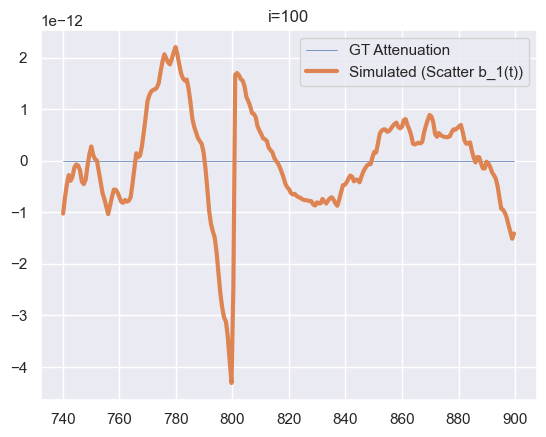

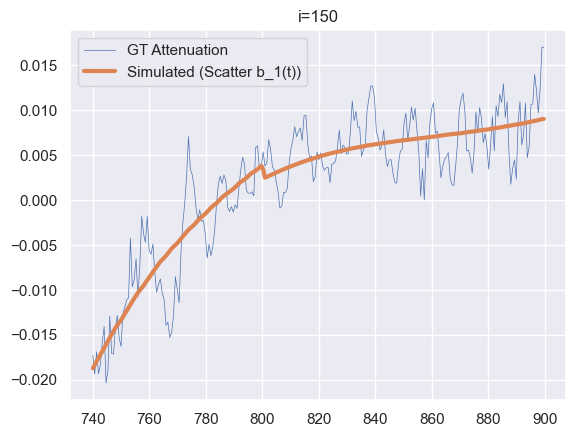

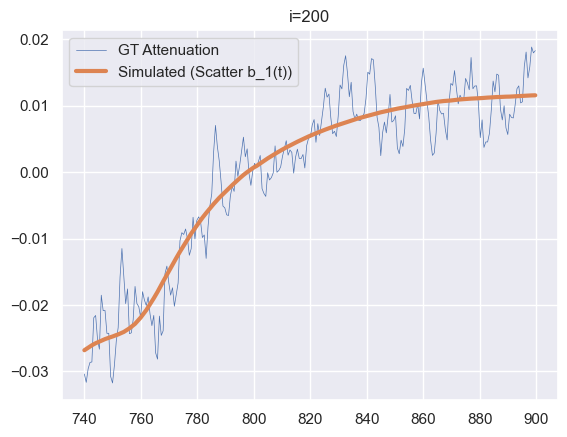

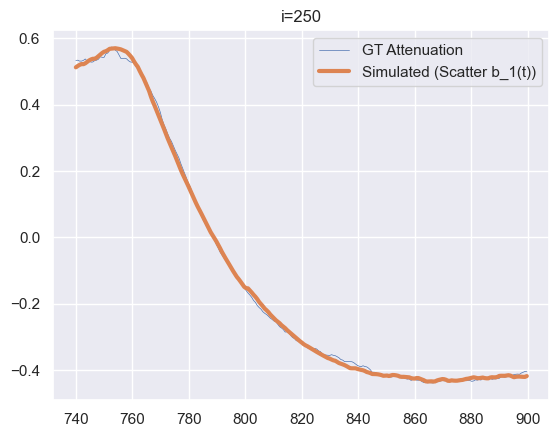

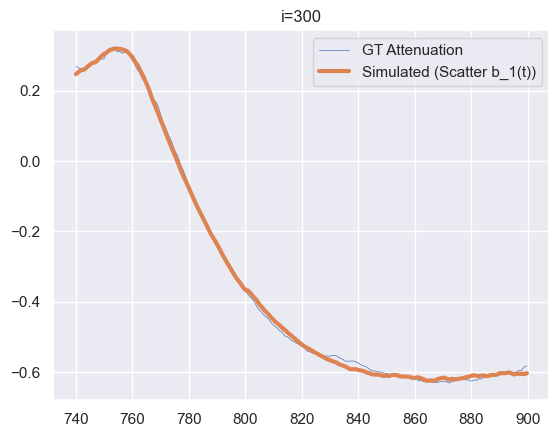

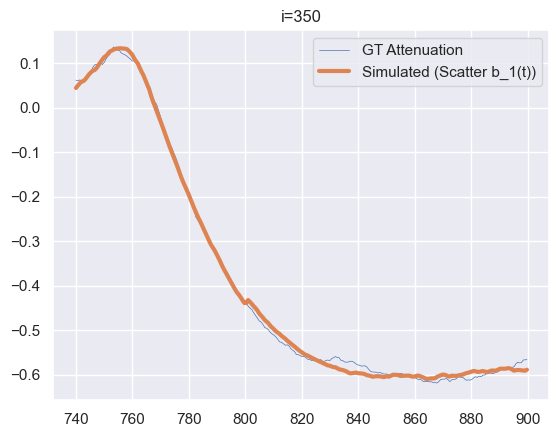

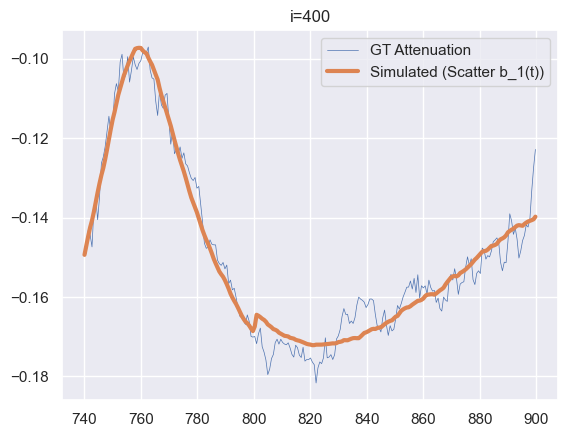

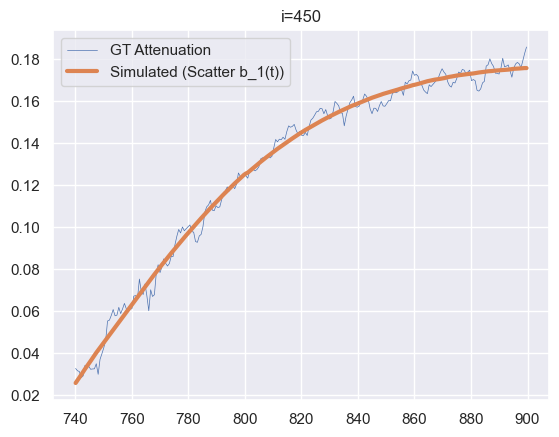

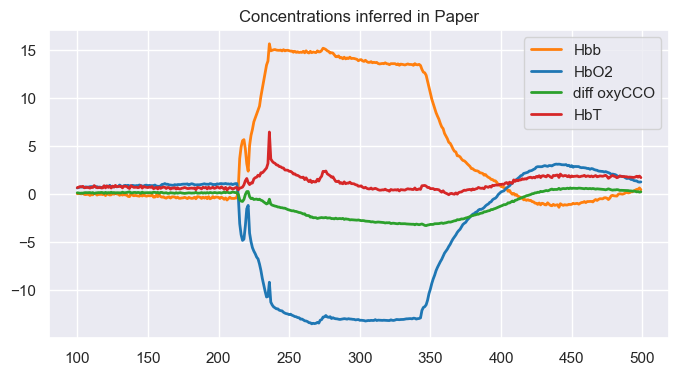

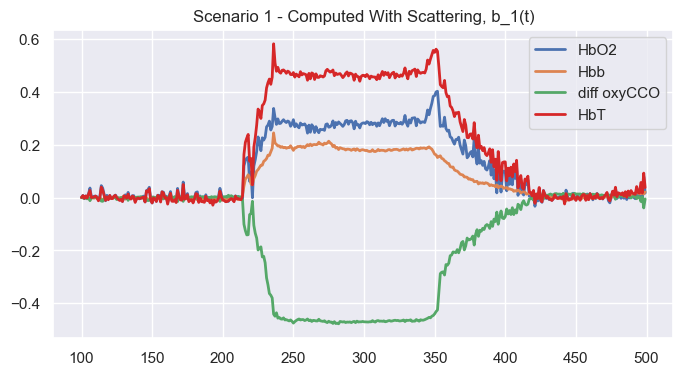

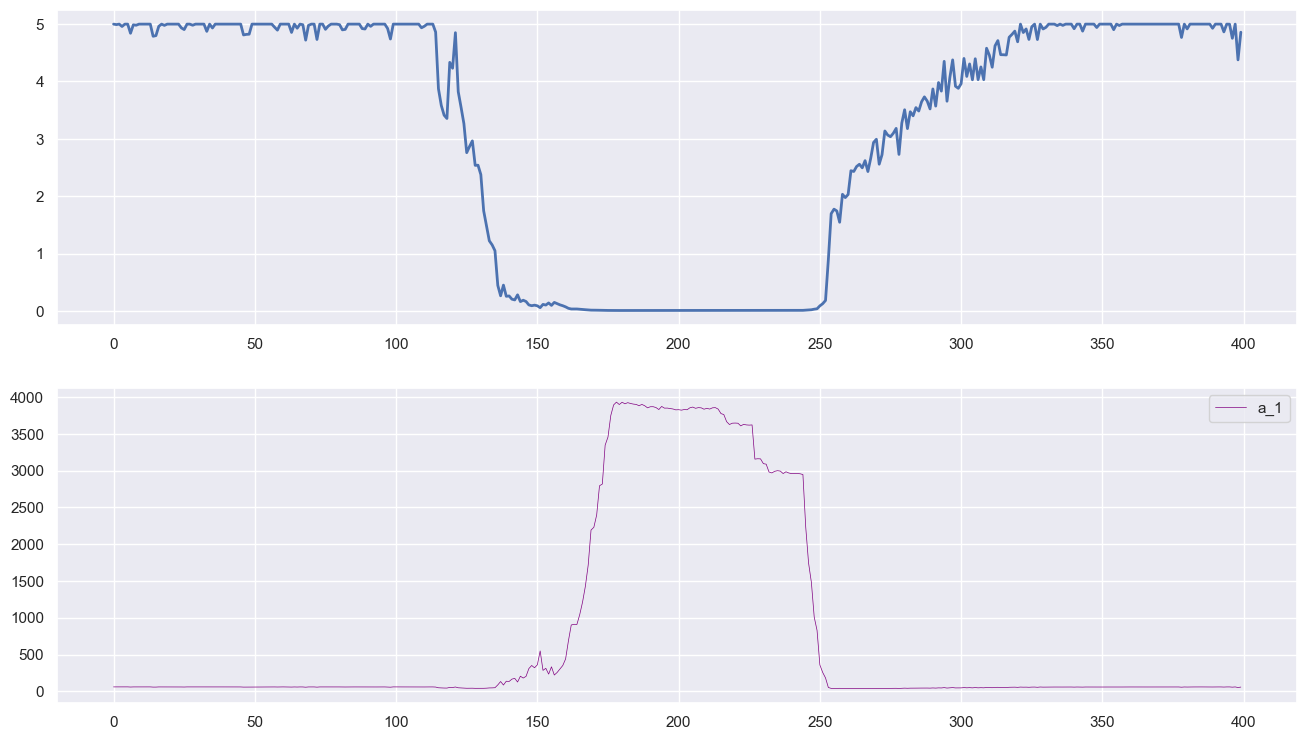

In [20]:
max_b1 = 5
max_a1 = 60

spectr_calib_smooth = smooth_spectral(spectr_calib, 5)
M_water = np.hstack((M, y_water[:, np.newaxis]))
M_ones = np.hstack((M, np.ones((M.shape[0], 1))))
M_water_ones = np.hstack((M_ones, y_water[:, np.newaxis]))

# a_t1, b_t1 = scenario_1_search_t1(spectr_calib_smooth, M)
# print(a_t1, b_t1)
# error, delta_c_i_list, a_list, b_list = scenario_1_given_t1(spectr_calib_smooth, a_t1, b_t1, M, need_plot=True)
# print("Mean error:", error)

# a_t1, b_t1 = scenario_1_search_t1(spectr_calib_smooth, M_water)
a_t1, b_t1 = 60,5
# print(a_t1, b_t1)
# error, delta_c_i_list, a_list, b_list = scenario_1_given_t1(spectr_calib_smooth, a_t1, b_t1, M_water, need_plot=True)
# print("Mean error:", error)

# a_t1, b_t1 = scenario_1_search_t1(spectr_calib_smooth, M_ones)
# print(a_t1, b_t1)
error, delta_c_i_list, a_list, b_list = scenario_1_given_t1(spectr_calib_smooth, a_t1, b_t1, M_ones, need_plot=True)
print("Mean error:", error)

# a_t1, b_t1 = scenario_1_search_t1(spectr_calib_smooth, M_water_ones)
# print(a_t1, b_t1)
# error, delta_c_i_list, a_list, b_list = scenario_1_given_t1(spectr_calib_smooth, a_t1, b_t1, M_water_ones, need_plot=True)
# print("Mean error:", error)



# normalization does not make sense because rescaling of the spectum just results in a constant offset in the attenuation




We observe many different values lead to similar errors.

# Scenario 2
We now try
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a\left[\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right]\right)
$$
with $a=1$.

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_2_given_t1(img, img_darkcount, img_whitecount, b_i_t1, need_plot=True, plot_only_concentrations=False, include_water=False):
    #Initialization
    
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules

    if include_water:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                    np.asarray(y_hb_f),
                                    np.asarray(y_coxa - y_creda),
                                    np.asarray(y_water))))        
    else:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                    np.asarray(y_hb_f),
                                    np.asarray(y_coxa - y_creda))))
    #                                np.asarray(y_water))))

    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
             
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","water","diff cc red","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/20, label=coef[i]+"/20", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(b_i, b_i_t1):
        result = 1*((((wavelengths/500)**(-b_i[0]))) - (((wavelengths/500)**(-b_i_t1[0])))) / (1-0.9)
        return result
    
    def f(X,*arg):
        b = arg[0]
        b_i_t1 = arg[1]
        delta_c_i = X[:m]
        b_i = X[m:(m+1)]
        return (M @ delta_c_i) + S(b_i, b_i_t1) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def plot_errors(no_scatter, scatter_fixed_b1, scatter, min_b1):
        plt.figure()
        x = np.array([0,1,2])
        #x = np.array([0,1])
        y = (np.array([no_scatter, scatter_fixed_b1, scatter]) - no_scatter) / no_scatter
        #y = (np.array([no_scatter, scatter_fixed_b1]) - no_scatter) / no_scatter
        my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2)), 'Scatter b_1(t)']
        #my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2))]
        plt.xticks(x, my_xticks)
        plt.plot(x,y)
        plt.ylabel("Error: Percentage Change")
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+1)
    current_x[-1] = 1
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [max_b1])
    
    for i in range(1, cut+1):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=(b, b_i_t1), bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        #coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        b_s.append(result.x[m])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        found_spectrum = f(result.x, *(0,b_i_t1))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            #plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list, a_s, "Scenario 2 - Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)
    return sum(errors_no_scatter), sum(errors_scatter)

In [ ]:
def scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=True, include_water=False):
    bs_i_t1 = np.linspace(0, max_b1, 10)
    
    min_val = np.zeros(bs_i_t1.shape)
    
    for i in tqdm(range(len(bs_i_t1))):
        min_val[i] = scenario_2_given_t1(img, img_darkcount, img_whitecount, [bs_i_t1[i]], need_plot=False, include_water=include_water)[1]
        #print(bs_i_t1[i], min_val[i])

    if need_plot:
        plt.plot(bs_i_t1, min_val)
        plt.xlabel("b_1(t_1)")
        plt.ylabel("Error")

    min_val_index = np.unravel_index(min_val.argmin(), min_val.shape)
    #print(min_val_index)
    return bs_i_t1[min_val_index]

In [ ]:
min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount)

In [ ]:
scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=True)

# Scenario 3
We observe how the error develops based on different values of $b$. Again note that the problem is linear for fixed $b$.
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+\Delta a\left(\frac{\lambda}{500nm}\right)^{-b}\right)
$$

In [19]:
import scipy
from scipy.linalg import pinv

def scenario_3(img, img_darkcount, img_whitecount, need_plot=True, plot_only_concentrations=False, include_water=False):
    #Initialization
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    #dark_full = img['darkcount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules

    if include_water:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda),
                                np.asarray(y_water))))
    else:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda))))
    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
        
            
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","water","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="Delta a", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def find_min_b1():
        bs = np.linspace(0, max_b1, 100)
        errors = []
        errors_no_scatter = [] #should all be the same value
        for b in tqdm(bs):
            error_scatter, error_no_scatter = run_opti_b1(b)
            errors.append(error_scatter)
            errors_no_scatter.append(error_no_scatter)

        if need_plot:
            plt.figure()
            plt.plot(bs, errors)
            plt.xlabel("Fixed b_1")
            plt.ylabel("Error")

        min_b1 = bs[np.argmin(errors)]
        print("min_b1 = " + str(min_b1))
        return min_b1 #returns the minimum b_1

    #first optimize for b_1

    min_b1 = find_min_b1()
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    for i in tqdm(range(1, cut+1)):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        
        coef_list_no_scatter.append(result_no_scatter)
        coef_list_min_b1.append(coefs_min_b1[:m])
        
        a_s_min_b1.append(coefs_min_b1[m])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter_min_b1.append(error_scatter_min_b1)
    
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list_min_b1, a_s_min_b1, "Computed With Scattering, b_1 = " + str(round(min_b1,2)) + ')')

    if not need_plot and plot_only_concentrations:
        plot_concentrations(coef_list_min_b1, a_s_min_b1, "Scenario 3 - Computed With Scattering, b_1 = " + str(round(min_b1,2)) + ')')

    return sum(errors_no_scatter), sum(errors_scatter_min_b1), min_b1

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


min_b1 = 5.0


 79%|██████████████████████████████        | 792/1000 [00:00<00:00, 3762.20it/s]/tmp/ipykernel_23173/4000487055.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2429.40it/s]


(192.58453858059858, 172.5046959367026, 5.0)


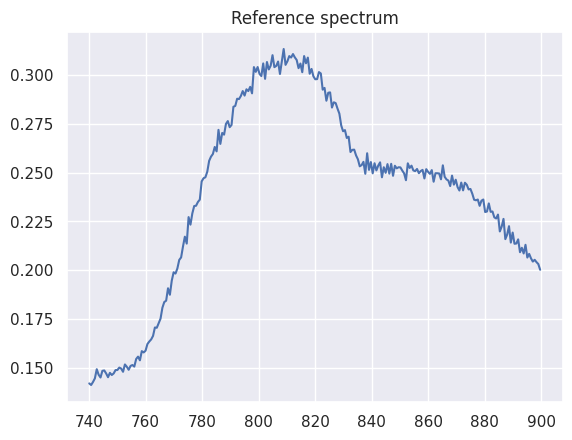

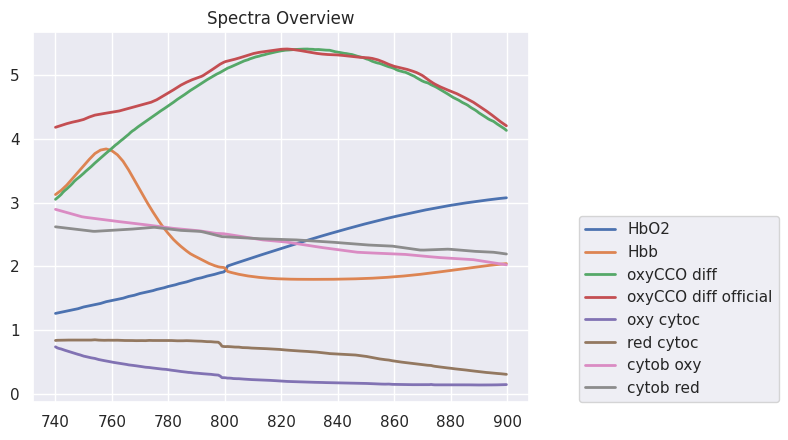

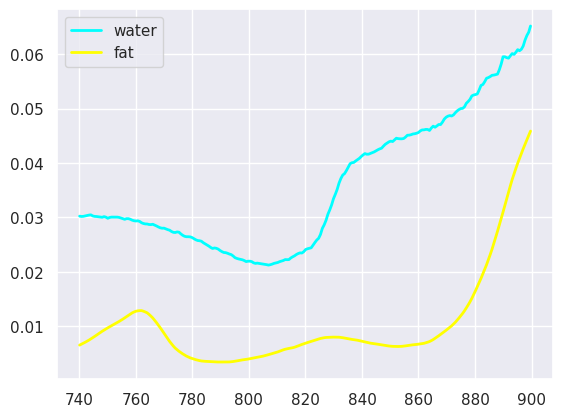

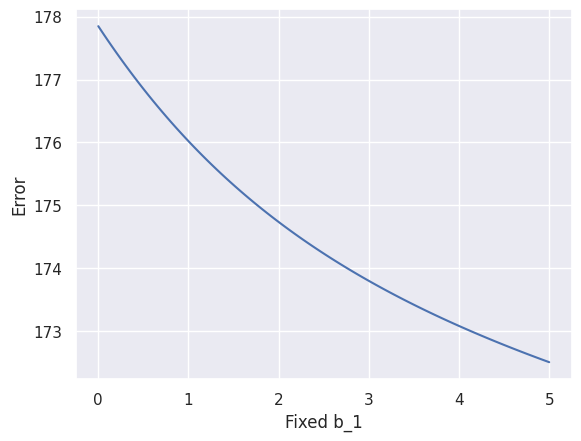

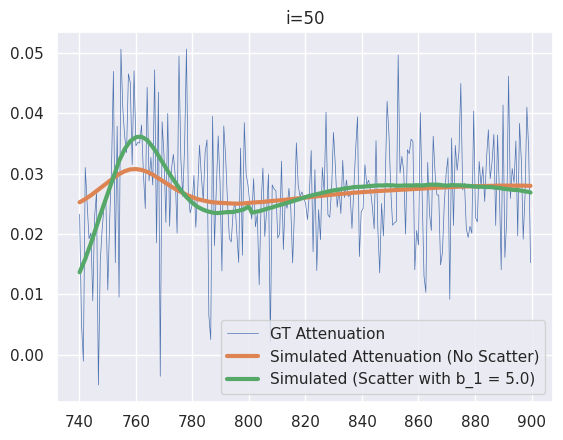

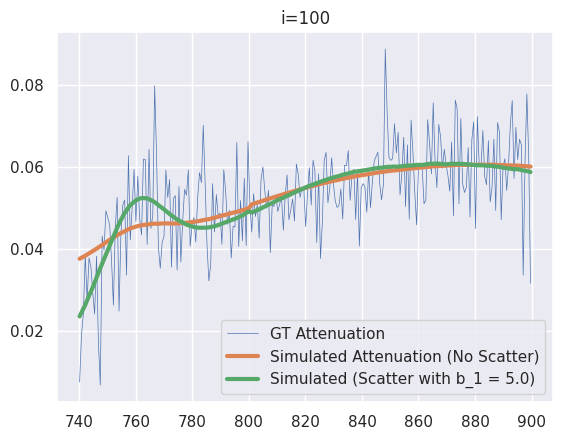

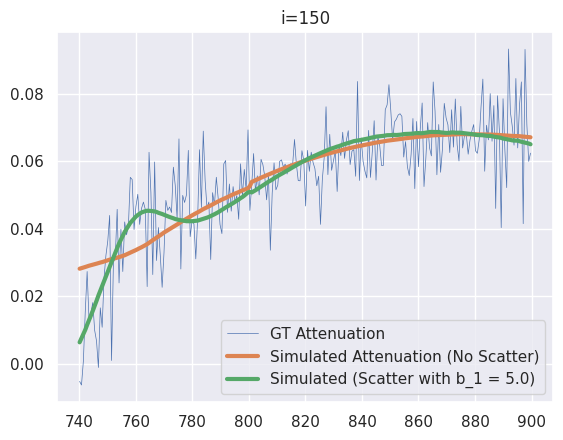

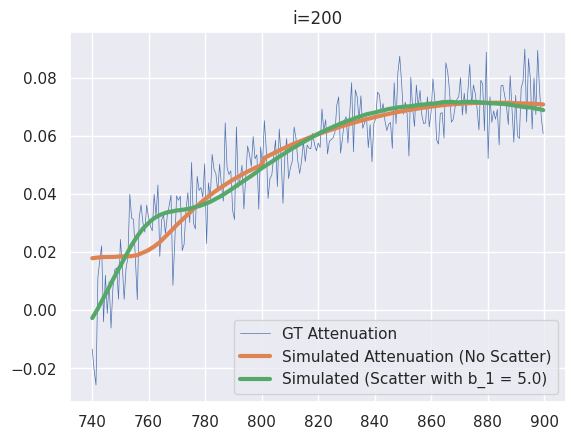

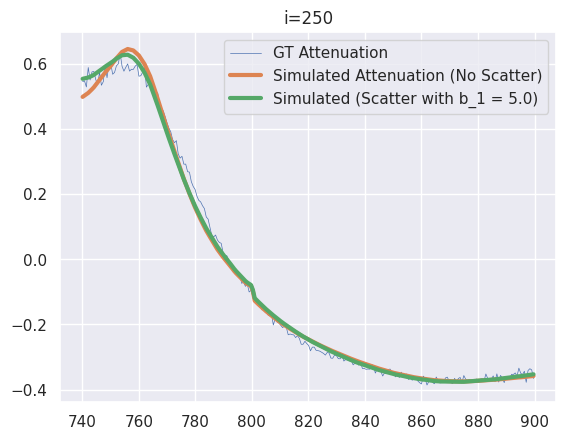

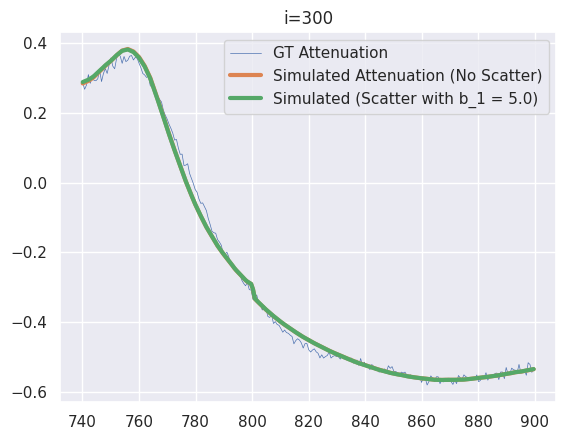

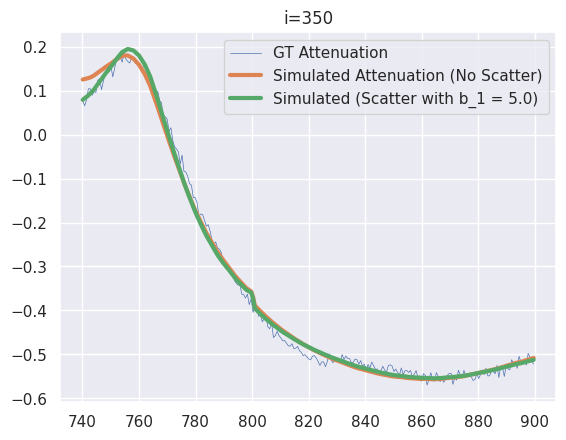

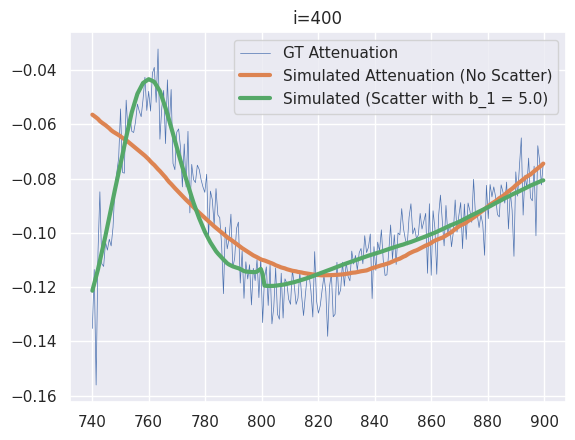

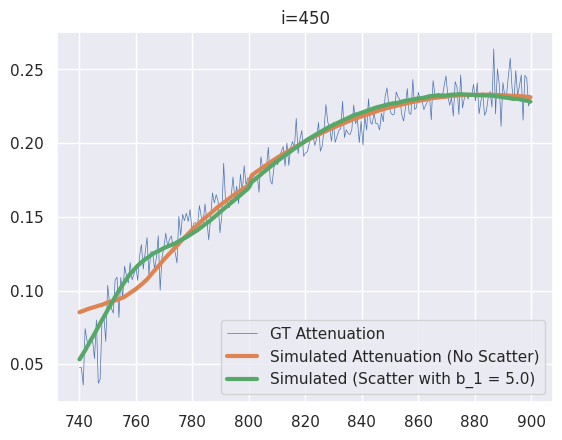

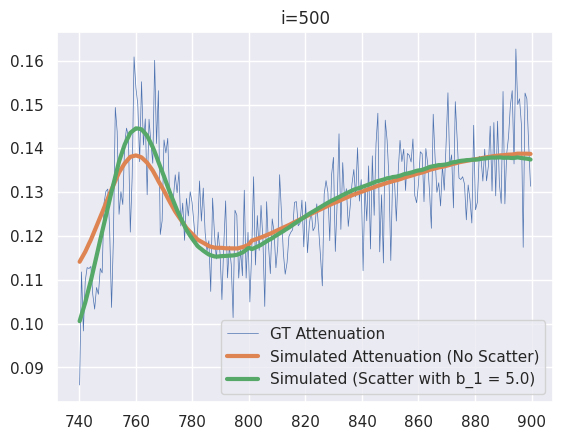

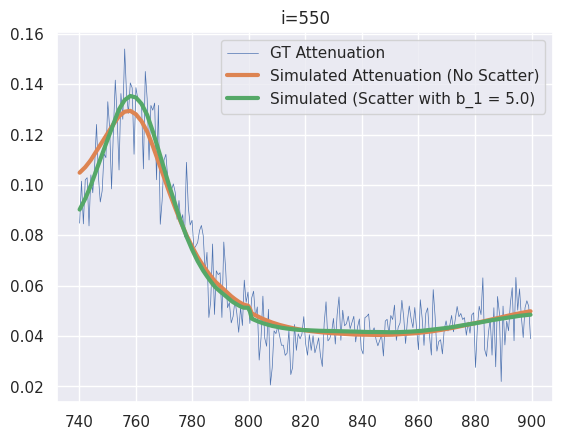

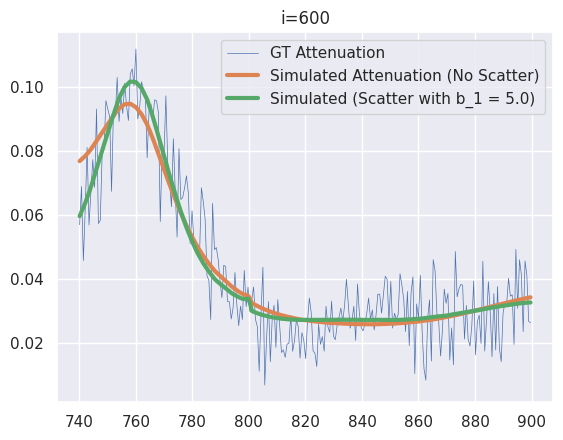

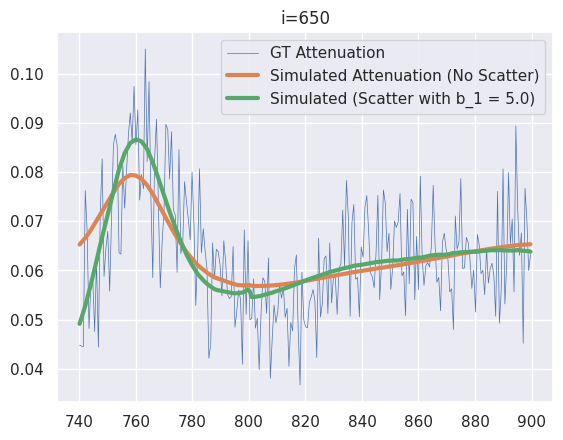

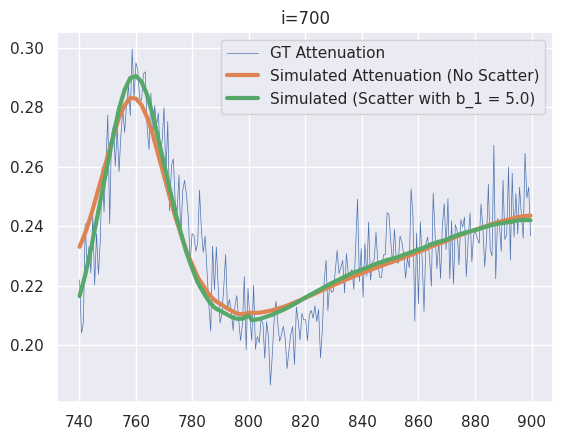

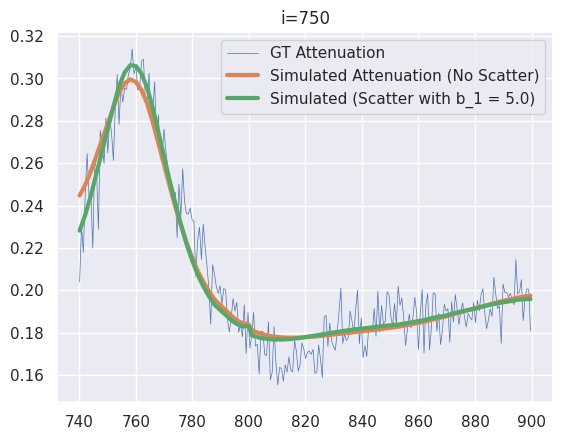

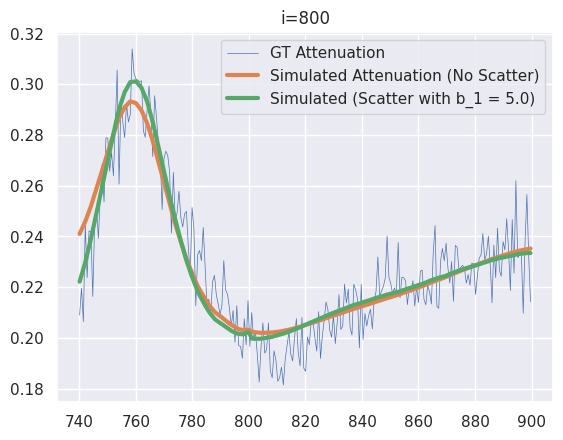

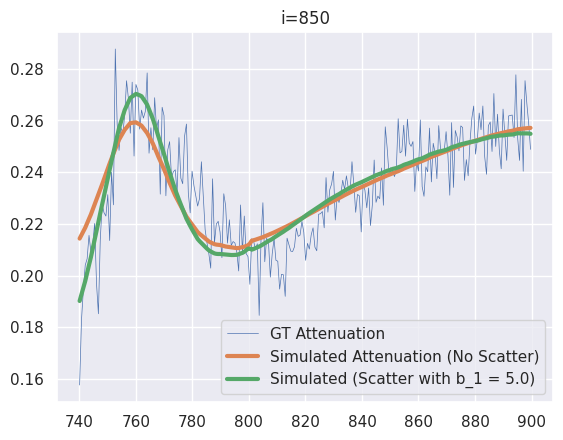

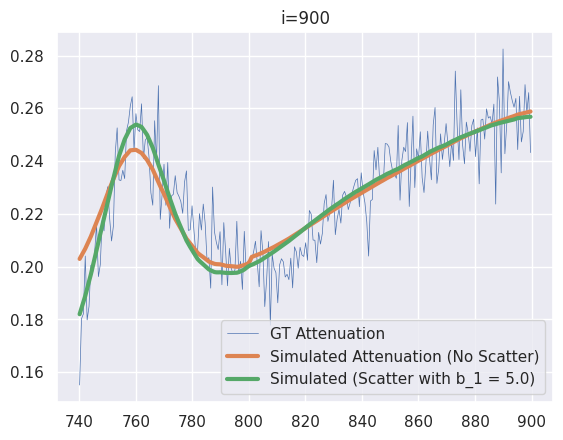

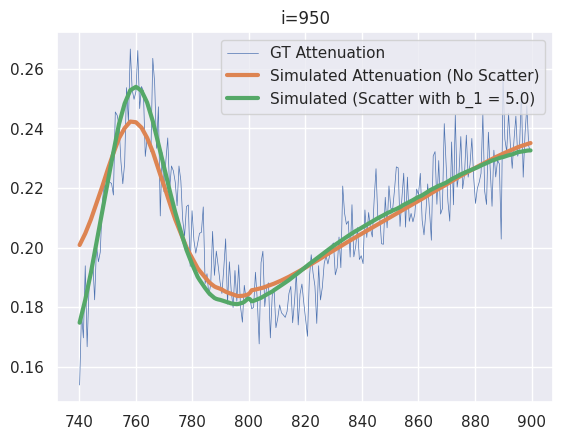

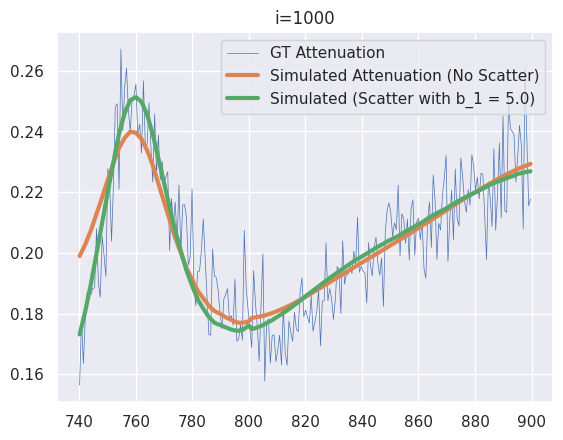

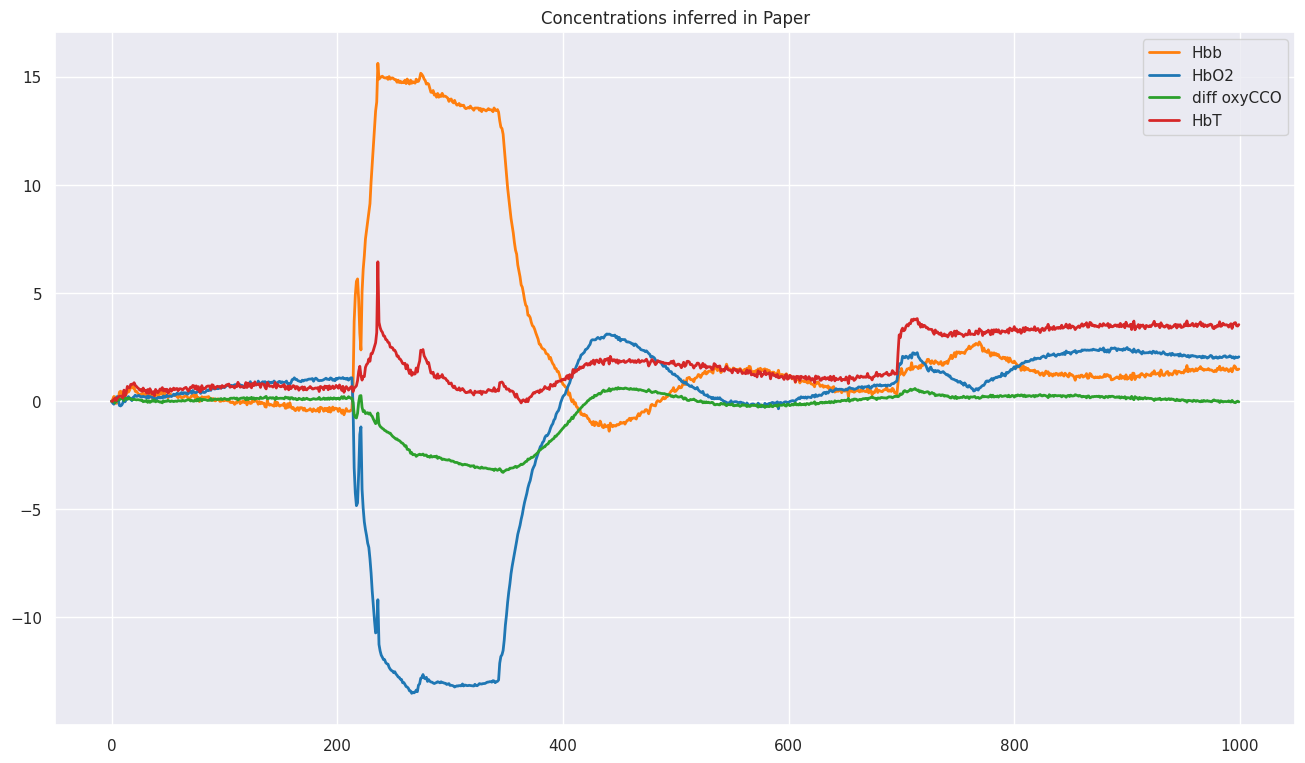

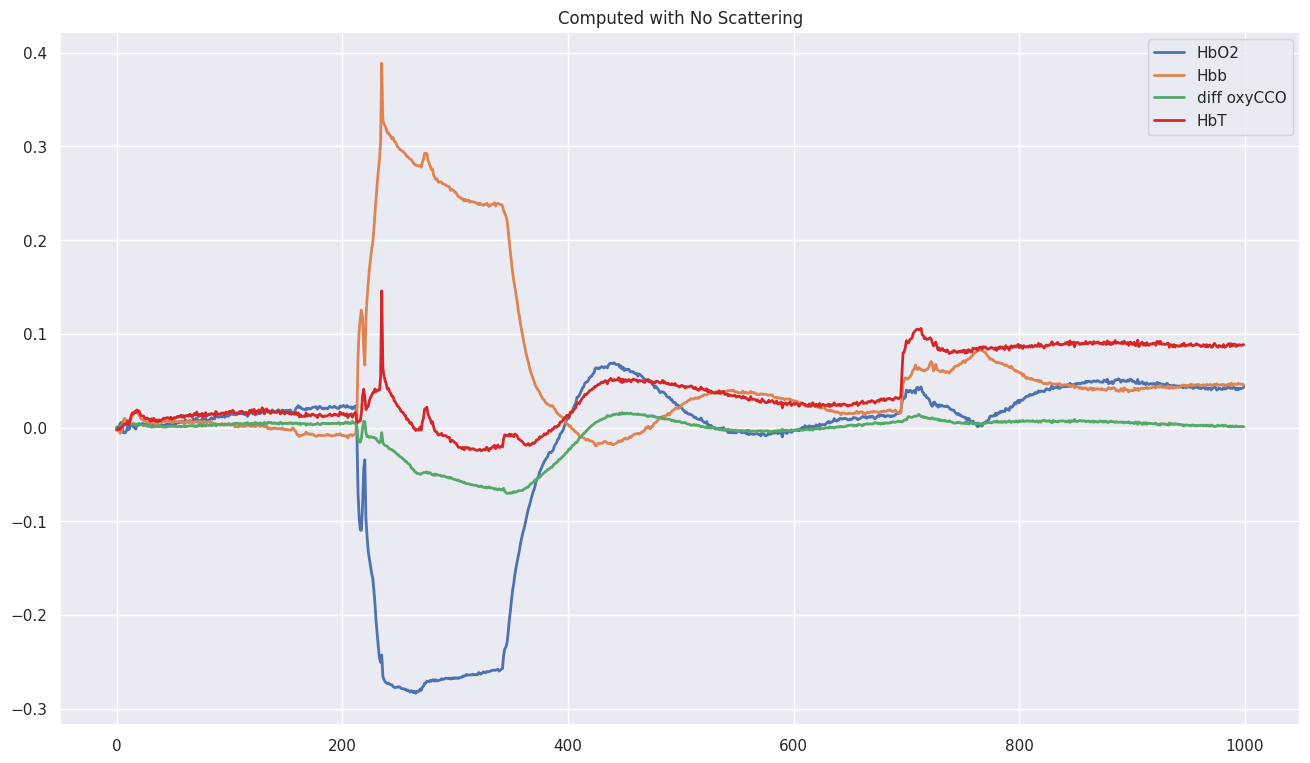

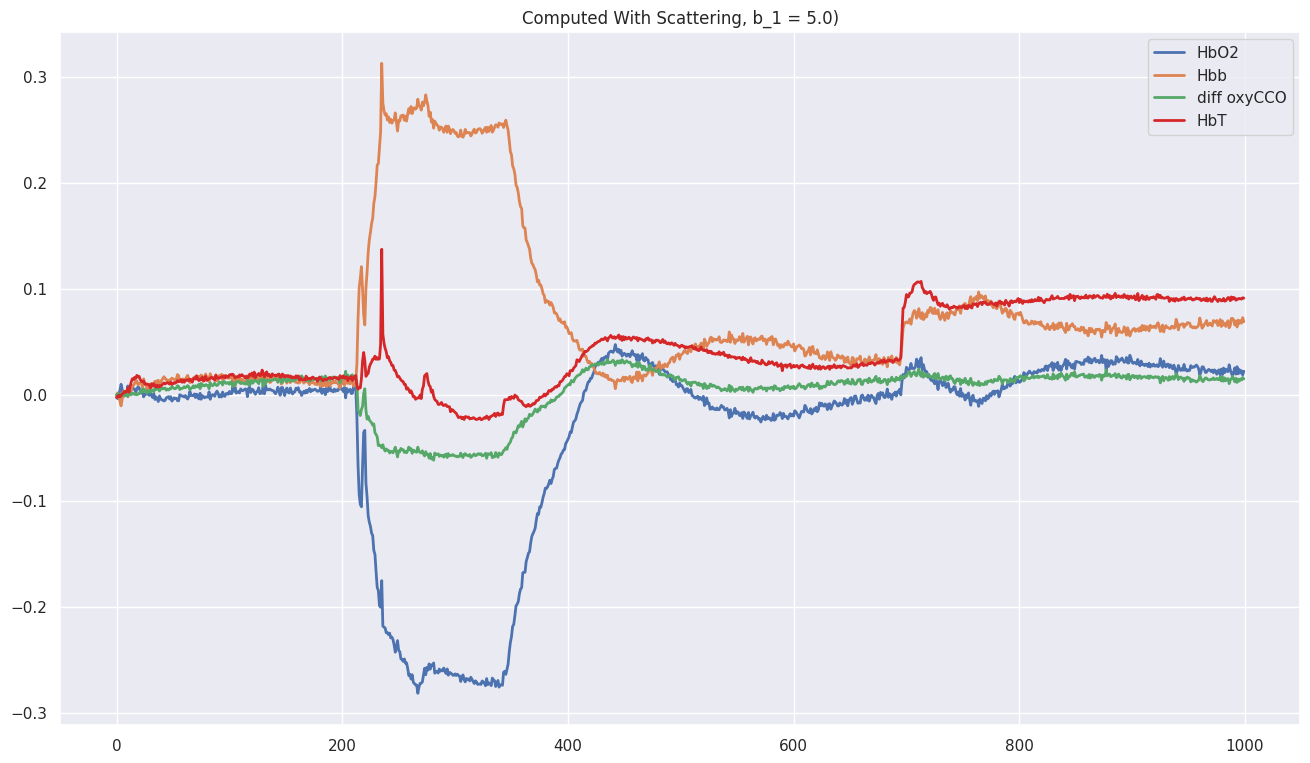

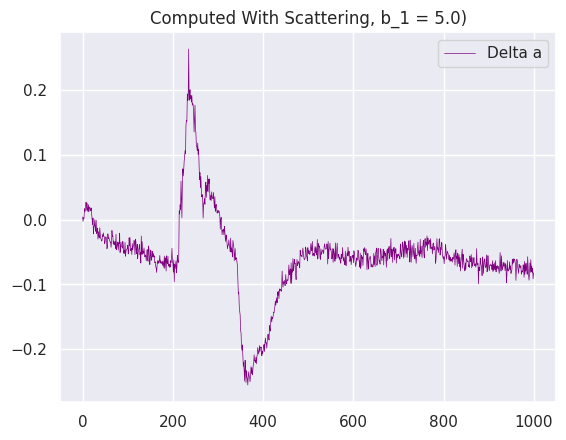

In [20]:
print(scenario_3(img, img_darkcount, img_whitecount, need_plot=True))

# Scenario 4
We assume that
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}\right)
$$

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_4(img, img_darkcount, img_whitecount, need_plot=True, plot_only_concentrations=False):
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda))))
    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
        
            
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a(t)", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(G_tilde, b_i):
        result = (((wavelengths[...,None]/500)**(-b_i[0])) @ G_tilde) / (1-0.9)
        return result
    
    def f(X,*b):
        delta_c_i = X[:m]
        G_tilde_i = X[m:(m+1)]
        b_i = X[(m+1):(m+2)]  
        return (M @ delta_c_i) + S(G_tilde_i, b_i) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+2)
    current_x[-1] = 1
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [-np.inf, 0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [np.inf, max_b1])
    
    for i in tqdm(range(1, cut+1)):
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=b, bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        a_s.append(result.x[m])
        b_s.append(result.x[m+1])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        #found_spectrum = np.exp(-(f(result.x, 0))) * ref_spectr
        found_spectrum = (f(result.x, 0))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations(coef_list, a_s, "Scenario 4 - Computed With Scattering, b_1(t)")

        
    return sum(errors_no_scatter), sum(errors_scatter)

In [ ]:
scenario_4(img, img_darkcount, img_whitecount, need_plot=True)

# Comparison of different scenarios for single piglet

For timepoints $i=1,\dots,n$, each considered scenario has the following amount of scattering parameters:

- Scenario 1: $2n$ parameters ($n$ linear parameters $a(t_i)$, $n$ nonlinear parameters $b(t_i)$)
- Scenario 2: $n$ parameters ($n$ nonlinear parameters $b(t_i)$)
- Scenario 3: $n+1$ parameters ($n$ linear parameters $\Delta a$, one nonlinear parameter $b$)
- Scenario 4: $2n-2$ parameters ($n-1$ linear parameters, $n-1$ nonlinear parameters)


In [ ]:
b_1, a_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
error_no_scatter_scenario1, error_scenario1 = scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=False, plot_only_concentrations=True)
print("Finished scenario 1 - found a(t_1) = ", a_1, ", b(t_1) = ", b_1)

min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
error_no_scatter_scenario2, error_scenario2 = scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=False, plot_only_concentrations=True)
print("Finished scenario 2 - found b(t_1) = ", min_b1)

error_no_scatter_scenario3, error_scenario3, min_b1_sc3 = scenario_3(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)
print("Finished scenario 3, found b = ", min_b1_sc3)

error_no_scatter_scenario4, error_scenario4 = scenario_4(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)
print("Finished scenario 4")

assert(error_no_scatter_scenario1 == error_no_scatter_scenario2 == error_no_scatter_scenario3 == error_no_scatter_scenario4)

plt.figure()
x = np.array([0,1,2,3,4])
y = (np.array([error_no_scatter_scenario1, error_scenario2, error_scenario3, error_scenario4, error_scenario1]) - error_no_scatter_scenario1) / error_no_scatter_scenario1
my_xticks = ['No Scatter','Scenario 2','Scenario 3','Scenario 4','Scenario 1']
plt.xticks(x, my_xticks)
plt.plot(x,y)
plt.ylabel("Error: Percentage Change")

# Comparison of different scenarios for 10 piglets

In [ ]:
from tqdm.autonotebook import tqdm

names = []
imgs = []
imgs_darkcount = []
imgs_whitecount = []

names.append("LWP479")
imgs.append(scipy.io.loadmat(dataset_path + 'lwp479-HI+saline/LWP479_Ws_05Dec2016.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'lwp479-HI+saline/LWP479_DarkCount_05Dec2016.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'lwp479-HI+saline/refSpectrum.mat'))

names.append("LWP480")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP480/LWP480_Ws_12Dec2016.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP480/LWP480_DarkCount_12Dec2016.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP480/refSpectrum.mat'))

names.append("LWP484")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP484/LWP484_Ws_23Jan2017.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP484/LWP484_DarkCount_23Jan2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP484/refSpectrum.mat'))

names.append("LWP488")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP488/LWP488_Ws_13Feb2017.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP488/LWP488_DarkCount_13Feb2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP488/refSpectrum.mat'))

names.append("LWP490")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP490/LWP490_Ws_27Feb2017.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP490/LWP490_DarkCount_27Feb2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP490/refSpectrum.mat'))

names.append("LWP498")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP498/LWP498_Ws_24Apr2017_15.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP498/LWP498 _DarkCount_24Apr2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP498/refSpectrum.mat'))

names.append("LWP503")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP503/LWP503_Ws_05_Jun_2017_15   8.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP503/LWP503_DarkCount_05Jun2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP503/refSpectrum.mat'))

names.append("LWP504")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP504/LWP504_Ws_12Jun_2017_17   1.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP504/LWP504_DarkCount_12Jun2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP503/refSpectrum.mat'))

names.append("LWP507")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP507/LWP507_Ws_10Jul_2017_16  55.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP507/LWP507_DarkCount_10Jul2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP507/refSpectrum.mat'))

names.append("LWP512")
imgs.append(scipy.io.loadmat(dataset_path + 'LWP512/LWP512_Ws_31Jul_2017_17  16.mat'))
imgs_darkcount.append(scipy.io.loadmat(dataset_path + 'LWP512/LWP512_DarkCount_31Jul2017.mat'))
imgs_whitecount.append(scipy.io.loadmat(dataset_path + 'LWP512/refSpectrum.mat'))

In [ ]:
plt.figure()
x = np.array([0,1,2,3,4])
my_xticks = ['No Scatter','Scenario 2','Scenario 3','Scenario 4','Scenario 1']
plt.xticks(x, my_xticks)
plt.ylabel("Error: Percentage Change")

for i in tqdm(range(len(names))):
    img = imgs[i]
    img_darkcount = imgs_darkcount[i]
    img_whitecount = imgs_whitecount[i]
    
    b_1, a_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
    error_no_scatter_scenario1, error_scenario1 = scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 1 - found a(t_1) = ", a_1, ", b(t_1) = ", b_1)
    
    min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
    error_no_scatter_scenario2, error_scenario2 = scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 2 - found b(t_1) = ", min_b1)
    
    error_no_scatter_scenario3, error_scenario3, min_b1_sc3 = scenario_3(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 3, found b = ", min_b1_sc3)
    
    error_no_scatter_scenario4, error_scenario4 = scenario_4(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 4")
    y = (np.array([error_no_scatter_scenario1, error_scenario2, error_scenario3, error_scenario4, error_scenario1]) - error_no_scatter_scenario1) / error_no_scatter_scenario1
    plt.plot(x,y,label=names[i])

plt.legend()

# Comparison of scenarios 2 and 3 for 10 piglets

In [ ]:
ys = []


for i in tqdm(range(len(names))):
    img = imgs[i]
    img_darkcount = imgs_darkcount[i]
    img_whitecount = imgs_whitecount[i]
    
    min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
    error_no_scatter_scenario2, error_scenario2 = scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=False, plot_only_concentrations=True)
    
    error_no_scatter_scenario3, error_scenario3, min_b1_sc3 = scenario_3(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)
    
    error_no_scatter_scenario4, error_scenario4 = scenario_4(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)

    assert(error_no_scatter_scenario2 == error_no_scatter_scenario3 == error_no_scatter_scenario4)
    
    y = (np.array([error_no_scatter_scenario2, error_scenario2, error_scenario3, error_scenario4]) - error_no_scatter_scenario2) / error_no_scatter_scenario2
    ys.append(y)

In [ ]:
plt.figure()
x = np.array([0,1,2,3])
my_xticks = ['No Scatter','Scenario 2','Scenario 3','Scenario 4']
plt.xticks(x, my_xticks)
plt.ylabel("Error: Percentage Change")
for i in range(len(names)):
    plt.plot(x,ys[i],label=names[i])
plt.legend()

# Scattering + Water

In [ ]:
left_cut = 740
right_cut = 930

min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, include_water=True)
scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=True, include_water=True)

In [ ]:
scenario_3(img, img_darkcount, img_whitecount, need_plot=True, include_water=True)

# Scenario 1 with RF

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_1_given_t1(img, img_darkcount, img_whitecount, b_i_t1, G_tilde_t1, need_plot=True, plot_only_concentrations=False):

    #Initialization
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules
    print(np.asarray(y_hbo2_f).shape)
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_cytoa_diff))))
    M_pinv = pinv(M)
    m=M.shape[1]

    print(M.shape)

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions

    def RF_calc(concentrations):
        coef_list = np.vstack(concentrations)
        nadir = np.min(coef_list[HI_start:HI_stop,2])
        recovery = np.mean(coef_list[HI_stop:(HI_stop+180),2])
        baseline = np.mean(coef_list[:HI_start,2])

        RF_found = (recovery - nadir) / (baseline - nadir)
        return RF_found
    
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diffCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)

        y_min, y_max = plt.gca().get_ylim()
        #plt.vlines([HI_start, HI_stop],y_min,y_max,linestyles='dashed',label='HI Period',colors='gray')
        plt.axvline(x=HI_start,color='gray',linestyle='--',label='HI + Recovery',alpha=0.6)
        plt.axvline(x=HI_stop,color='gray',linestyle='--',alpha=0.6)
        plt.axvline(x=HI_stop+180,color='gray',linestyle='--',alpha=0.6)
        plt.title("Concentrations inferred in Paper, oxCCO RF = "+str(np.round(RF_calc(concentrations),3)))
        plt.legend()
             
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        RF_oxCCO = np.round(RF_calc(coef_list),3)
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diffCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)

        plt.axvline(x=HI_start,color='gray',linestyle='--',label='HI + Recovery',alpha=0.6)
        plt.axvline(x=HI_stop,color='gray',linestyle='--',alpha=0.6)
        plt.axvline(x=HI_stop+180,color='gray',linestyle='--',alpha=0.6)
        
        plt.title(title + ", oxCCO RF = " + str(RF_oxCCO))
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(G_tilde, b_i, b_i_t1, G_tilde_t1):
        result = ((((wavelengths[...,None]/500)**(-b_i[0])) @ G_tilde) - (((wavelengths[...,None]/500)**(-b_i_t1[0])) @ G_tilde_t1)) / (1-0.9)
        return result
    
    def f(X,*arg):
        b = arg[0]
        b_i_t1, G_tilde_t1 = arg[1], arg[2]
        delta_c_i = X[:m]
        G_tilde_i = X[m:(m+1)]
        b_i = X[(m+1):(m+2)]  
        return (M @ delta_c_i) + S(G_tilde_i, b_i, b_i_t1, G_tilde_t1) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def plot_errors(no_scatter, scatter_fixed_b1, scatter, min_b1):
        plt.figure()
        x = np.array([0,1,2])
        #x = np.array([0,1])
        y = (np.array([no_scatter, scatter_fixed_b1, scatter]) - no_scatter) / no_scatter
        #y = (np.array([no_scatter, scatter_fixed_b1]) - no_scatter) / no_scatter
        my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2)), 'Scatter b_1(t)']
        #my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2))]
        plt.xticks(x, my_xticks)
        plt.plot(x,y)
        plt.ylabel("Error: Percentage Change")
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+2)
    current_x[-2] = G_tilde_t1[0]
    current_x[-1] = b_i_t1[0]
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [-np.inf, 0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [np.inf, max_b1])
    
    for i in range(1, cut+1):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=(b, b_i_t1, G_tilde_t1), bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        #coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        a_s.append(result.x[m])
        b_s.append(result.x[m+1])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        found_spectrum = f(result.x, *(0,b_i_t1, G_tilde_t1))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            #plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Scenario 1 - Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list, a_s, "Scenario 1 - Computed With Scattering, b_1(t)")
    return sum(errors_no_scatter), sum(errors_scatter), RF_calc(coef_list)

In [ ]:
def scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=True):
    bs_i_t1 = np.linspace(0, max_b1, 8)
    Gs_tilde_t1 = np.linspace(0,70,5)
    
    bs_i_t1, Gs_tilde_t1 = np.meshgrid(bs_i_t1, Gs_tilde_t1)
    min_val = np.zeros(bs_i_t1.shape)
    RFs = np.zeros(bs_i_t1.shape)
    
    for i in tqdm(range(bs_i_t1.shape[0])):
        for j in range(bs_i_t1.shape[1]):
            _, min_val[i,j], RFs[i,j] = scenario_1_given_t1(img, img_darkcount, img_whitecount, [bs_i_t1[i,j]], [Gs_tilde_t1[i,j]], need_plot=False)
            #print(bs_i_t1[i,j], Gs_tilde_t1[i,j], min_val[i,j])

    if need_plot:
        plt.figure()
        plt.pcolormesh(bs_i_t1, Gs_tilde_t1, min_val)
        plt.xlabel("b(t_1)")
        plt.ylabel("a(t_1)")
        plt.colorbar()
        plt.title("Errors")
        plt.figure()
        plt.pcolormesh(bs_i_t1, Gs_tilde_t1, RFs)
        plt.xlabel("b(t_1)")
        plt.ylabel("a(t_1)")
        plt.colorbar()
        plt.title("RFs oxCCO")

    min_val_index = np.unravel_index(min_val.argmin(), min_val.shape)
    
    return bs_i_t1[min_val_index[0], min_val_index[1]], Gs_tilde_t1[min_val_index[0], min_val_index[1]]

In [ ]:
a_1, b_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount)
scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=True)

In [ ]:
x